In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import jax
import jax.numpy as jnp

import hemcee

from src.logprob import build_u1_logprob
from src.statistics import topo_charge

import matplotlib.pyplot as plt

# Log Probability Function for U(1) Gauge Theory

In [45]:
# Set up the U1 gauge action
beta = 7.0
VolShape = (8, 8)
Nd = len(VolShape)
log_prob, _ = build_u1_logprob(beta=beta, VolShape=VolShape)

# Get Samples

In [46]:
# Set up hemcee sampler
total_chains = 10
dim = int(jnp.prod(jnp.array(VolShape)) * Nd)
sampler = hemcee.HamiltonianEnsembleSampler(
    total_chains=total_chains, 
    dim=dim, 
    log_prob=log_prob,
)

# Generate initial state
seed = 1
key = jax.random.PRNGKey(seed)
keys = jax.random.split(key, 2)

initial_state = jax.random.uniform(keys[0], 
                                   shape=(total_chains, dim), 
                                   minval=0, maxval=2 * jnp.pi)

# Run MCMC sampling
num_samples = 8000 * 3
warmup = 500
samples = sampler.run_mcmc(keys[1], initial_state, num_samples, warmup=warmup)

print('Sampling complete!')
print('Diagonistics:')
print(sampler.diagnostics_main)
print(sampler.da_state)

Using 10 total chains: Group 1 (5), Group 2 (5)
Sampling complete!
Diagonistics:
{'accepts': Array([18604., 17367., 18732., 17499., 15459., 18544., 18215., 19225.,
       21129., 19023.], dtype=float32), 'acceptance_rate': Array([0.7751667 , 0.723625  , 0.7805    , 0.729125  , 0.644125  ,
       0.7726667 , 0.75895834, 0.80104166, 0.880375  , 0.792625  ],      dtype=float32)}
DAState(iteration=Array(500, dtype=int32, weak_type=True), step_size=Array(0.0375463, dtype=float32), H_bar=Array(0.00745098, dtype=float32), log_epsilon_bar=Array(-3.2474558, dtype=float32))


# Statistics

In [47]:
samples_ShapedForLattice = samples.reshape((num_samples, total_chains, Nd) + VolShape)

### Autocorrelation

In [ ]:
hemcee.autocorr.integrated_time(samples)

### Topological Charge

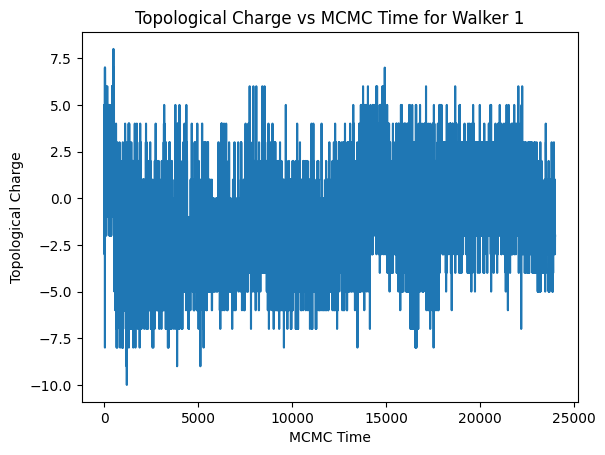

In [ ]:
walker_id = 1
samples_per_walker = samples_ShapedForLattice[:, walker_id, :, :, :]

plt.plot(topo_charge(samples_per_walker))
plt.xlabel('MCMC Time')
plt.ylabel('Topological Charge')
plt.title(f'Topological Charge vs MCMC Time for Walker {walker_id} at beta={beta}')
plt.show()